In [3]:
# Import radial_velocity_functions :: Run this to reimport without having to restart the whole notebook
import radial_velocity_functions
import importlib
importlib.reload(radial_velocity_functions)
from radial_velocity_functions import *

In [4]:
# Import calibration functions :: Run this to reimport without having to restart the whole notebook
import calibration_functions
importlib.reload(calibration_functions)
from calibration_functions import *

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import tqdm as tqdm
from tqdm import tqdm
import pandas as pd
from datetime import datetime
from scipy.interpolate import interp1d

plt.rcParams['font.size'] = 16
plt.rc("font", family="serif")

from os import walk

#### Illustration of the spectrum splitting into orders

In [49]:
# Code to convert wavelength to RGB

import sys
import os
import traceback
import optparse
import time
import logging

def wavelength_to_hex(wavelength, gamma=0.8):
    """ Modified this to return hex values """


    '''This converts a given wavelength of light to an 
    approximate RGB color value. The wavelength must be given
    in nanometers in the range from 380 nm through 750 nm
    (789 THz through 400 THz).

    Based on code by Dan Bruton
    http://www.physics.sfasu.edu/astro/color/spectra.html
    '''

    wavelength = float(wavelength)
    if wavelength >= 380 and wavelength <= 440:
        attenuation = 0.3 + 0.7 * (wavelength - 380) / (440 - 380)
        R = ((-(wavelength - 440) / (440 - 380)) * attenuation) ** gamma
        G = 0.0
        B = (1.0 * attenuation) ** gamma
    elif wavelength >= 440 and wavelength <= 490:
        R = 0.0
        G = ((wavelength - 440) / (490 - 440)) ** gamma
        B = 1.0
    elif wavelength >= 490 and wavelength <= 510:
        R = 0.0
        G = 1.0
        B = (-(wavelength - 510) / (510 - 490)) ** gamma
    elif wavelength >= 510 and wavelength <= 580:
        R = ((wavelength - 510) / (580 - 510)) ** gamma
        G = 1.0
        B = 0.0
    elif wavelength >= 580 and wavelength <= 645:
        R = 1.0
        G = (-(wavelength - 645) / (645 - 580)) ** gamma
        B = 0.0
    elif wavelength >= 645 and wavelength <= 750:
        attenuation = 0.3 + 0.7 * (750 - wavelength) / (750 - 645)
        R = (1.0 * attenuation) ** gamma
        G = 0.0
        B = 0.0
    else:
        R = 0.0
        G = 0.0
        B = 0.0
    R *= 255
    G *= 255
    B *= 255

    r = int(R)
    g = int(G)
    b = int(B)

    hex = "#{:02x}{:02x}{:02x}".format(r,g,b)
    return hex

In [50]:
filename = r"expres_tp/LFC_200907.1063.fits"
hdu1 = fits.open(filename)
data = hdu1[1].data.copy()

In [51]:


wavel = data["wavelength"]
x_len = len(wavel[0])
y_len = len(wavel)
matrix = np.empty((x_len, y_len), dtype=str)
matrix[:] = str(None)
for order in np.arange(len(wavel)):
    for pixel in np.arange(len(wavel[order])):
        lamb = wavel[order][pixel] 
        lamb = lamb * 0.1 # convert A -> nm
        hex = str(None)
        if lamb > 380 and lamb < 750:
            hex = wavelength_to_hex(lamb)
        matrix[pixel, order] = hex


# plt.figure(figsize=(16, 8))
# # plt.imshow(matrix, aspect="auto")
# plt.imshow(x=(x_len, y_len, matrix))

# orders_pix = np.array([data['wavelength'][o] for o in np.arange(len(data['wavelength']))]) # create 2d array
# plt.figure(figsize=(16, 8))
# plt.imshow(orders_pix, aspect="auto")

This is harder than expected and thinking about it, won't look very good with 86 orders anyway, you won't be able to see the individual colors, so I wil just make a dummy graphs.

Text(0, 0.5, 'Order')

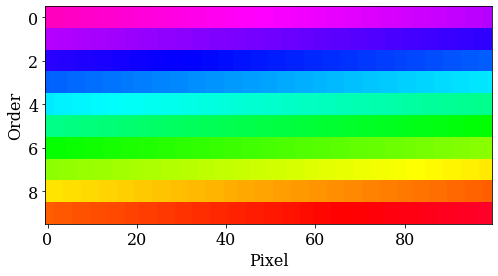

In [73]:
matrix = np.flip(np.arange(1000)).reshape(10, -1)
plt.figure(figsize=(8, 4))
plt.imshow(matrix, aspect="auto", cmap="gist_rainbow")
plt.xlabel("Pixel")
plt.ylabel("Order")

### Flat p-dist


In [100]:
def super_gauss(x, A=0.5, mu=0, sigma=-1.677, P=1.3, C=0, b = 0):
    z = (x - mu)**2 / (2 * sigma**2)
    return A * np.exp(-z**P) + C + b * (x - mu)


N_try = 0
N_points = 100000
x_accepted = np.zeros(N_points)
xmin, xmax = -10, 10
ymin, ymax = 0, 1

for i in range(N_points):
    
    while True:
        
        # Count the number of tries, to get efficiency/integral
        N_try += 1                    
        
        # Range that f(x) is defined/wanted in:
        x_test = np.random.uniform(xmin, xmax)  
        
        # Upper bound for function values:
        y_test = np.random.uniform(ymin, ymax)
        
        # If random y-value is under the function value, accept
        if super_gauss(x_test) > y_test:
            break

    x_accepted[i] = x_test


Text(0.5, 1.0, 'P-value dist')

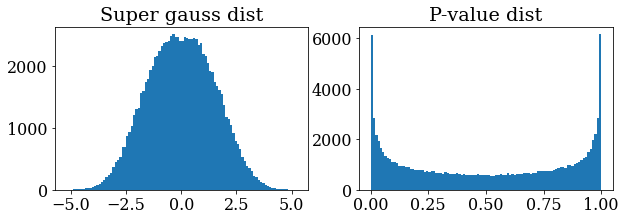

In [116]:
# xlin = np.linspace(-10, 10, 1000)
# plt.plot(xlin, super_gauss(xlin))

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,3))
ax1.hist(x_accepted, bins=100);
ax1.set_title("Super gauss dist")

from scipy import stats
ax2.hist(stats.norm.cdf(x_accepted), bins=100);
ax2.set_title("P-value dist")


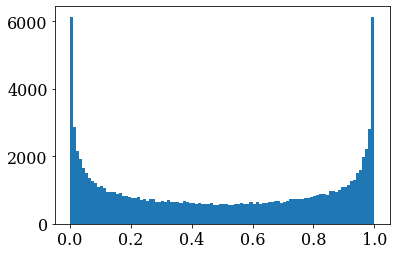

In [106]:
for n in np.arange(100):
    print(x_accepted[n], stats.norm.cdf(x_accepted[n]))

-1.4319456312216552 0.07607969083069267
0.2947775984879364 0.6159181098681656
3.8970670550447224 0.999951317666229
-1.047911956378364 0.14733958654017754
-0.2600045757388152 0.3974301220129265
0.17613948319558936 0.5699078186465711
2.5655185327972916 0.9948489141157774
1.6617791303389478 0.9517214658979878
0.3484669162601861 0.6362552221587721
-1.1747080904540592 0.12005576073408719
0.9191662175924105 0.82099568091175
-1.2897900515053422 0.09856178151596279
-1.247744231255858 0.10606236884134496
-1.8028770947202055 0.035703759498764684
0.05669802399418167 0.5226071259451796
-1.3522522477171623 0.0881473173585241
1.5879517002832522 0.9438513693205252
0.9419360911024981 0.8268873195730813
3.0895435014974666 0.9989976782627035
-0.17208306782613292 0.43168611205286134
-1.7345118579445327 0.04141365181141107
-3.7548294416101484 8.672977837023868e-05
1.6043862369665707 0.9456855285893657
-1.2406224323028088 0.10737263055515872
-0.2577052183766355 0.3983172092139387
1.2541044014815839 0.89509

In [112]:
stats.norm.cdf(1)

0.8413447460685429